In [14]:
# Import packages

import rioxarray
from planetary_computer import sign
import pystac
import matplotlib.pyplot as plt
from collections import defaultdict
from shapely.geometry import shape
import json
import glob
import numpy as np
import rasterio
from rasterio.plot import show
import os
from rasterio.enums import Resampling

scratch_dir = './scratch' 

def create_requirements():
    os.system('pip freeze > requirements.txt')
    #os.system("conda env export > environment.yml")

create_requirements()

In [15]:
def save_bands_as_tif(item_url, bands, output_dir, xmin, xmax, ymin, ymax, pre_post):
    item = pystac.Item.from_file(item_url)
    signed_item = sign(item)
    
    print(f"Bounding Box Coordinates {pre_event_url}: {shape(signed_item.geometry).bounds}")
    
    for band in bands:
        asset_href = signed_item.assets[band].href
        ds = rioxarray.open_rasterio(asset_href)
        ds_cropped = ds.rio.clip_box(minx=xmin, miny=ymin, maxx=xmax, maxy=ymax)
        output_filename = os.path.join(output_dir, f"{band}_{pre_post}.tif")
        ds_cropped.rio.to_raster(output_filename)

def get_crop_coords(xmin, xmax, ymin, ymax, side_length):
    xcenter = (xmin + xmax) / 2
    ycenter = (ymin + ymax) / 2

    new_xmin = xcenter - side_length / 2
    new_xmax = xcenter + side_length / 2
    new_ymin = ycenter - side_length / 2
    new_ymax = ycenter + side_length / 2

    return new_xmin, new_xmax, new_ymin, new_ymax


with open('Data/config.json', 'r') as json_file:
    config = json.load(json_file)
    
pre_event_url = config['pre_event_url']
post_event_url = config['post_event_url']
bands = config['bands']
xmin, xmax, ymin, ymax = config['coords']
side_length = config['side_length']
output_dir = config['output_dir']

save_bands_as_tif(pre_event_url, bands, output_dir, xmin, xmax, ymin, ymax, "Pre")
save_bands_as_tif(post_event_url, bands, output_dir, xmin, xmax, ymin, ymax, "Post")

Bounding Box Coordinates: (34.0435717, 30.6263903, 35.2117462, 31.6311926)
Bounding Box Coordinates: (34.0435717, 30.6263903, 35.2117462, 31.6311926)


Sentinel-2 is a multispectral twin satellite launched by European Space Agency (ESA) in 2015 (Sentinel-2A) and 2017 (Sentinel-2B) with the main mission for land monitoring, emergency management, and security. Sentinel-2 acquires 13 bands, i.e., visible, near-infrared, and shortwave-infrared (SWIR) at a spatial resolution of 10 m (B2, B3, B4, B8), 20 m (B5, B6, B7, B8A, B11, B12), and 60 m (B1, B9, B10). This satellite has 5 days revisit time with a coverage of the entire globe (European Space Agency, 2015). The pre-event image was acquired on July 7, 2018. Due to the limited availability of cloud-free in the affected area, the post-event image was acquired on September 30, 2018, almost 41 days after the actual earthquake. The visible (blue, green, red) and near-infrared bands with 10 m spatial resolution were chosen for consistency with the Sentinel-1 data.


NDBI = (SWIR - NIR) / (SWIR + NIR)

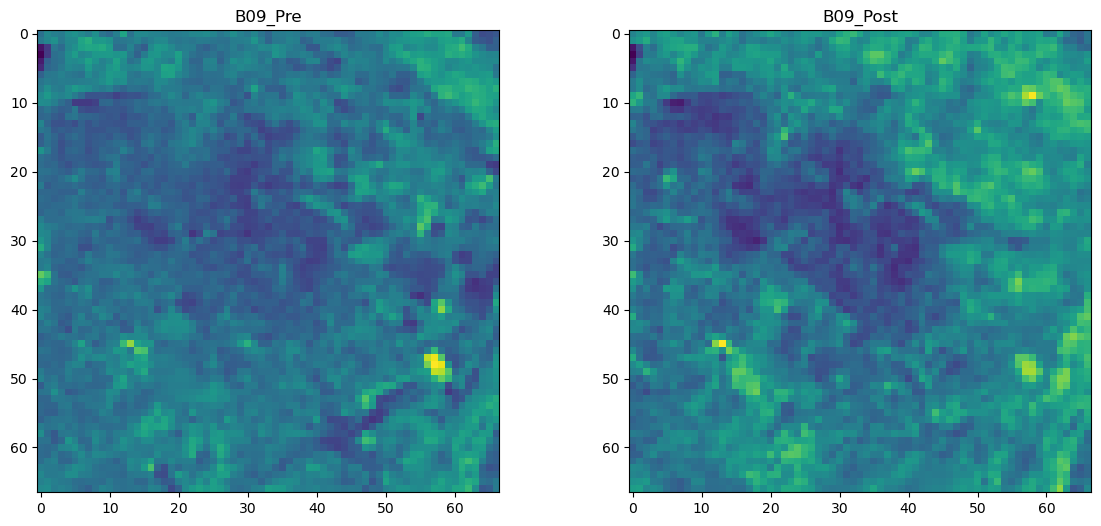

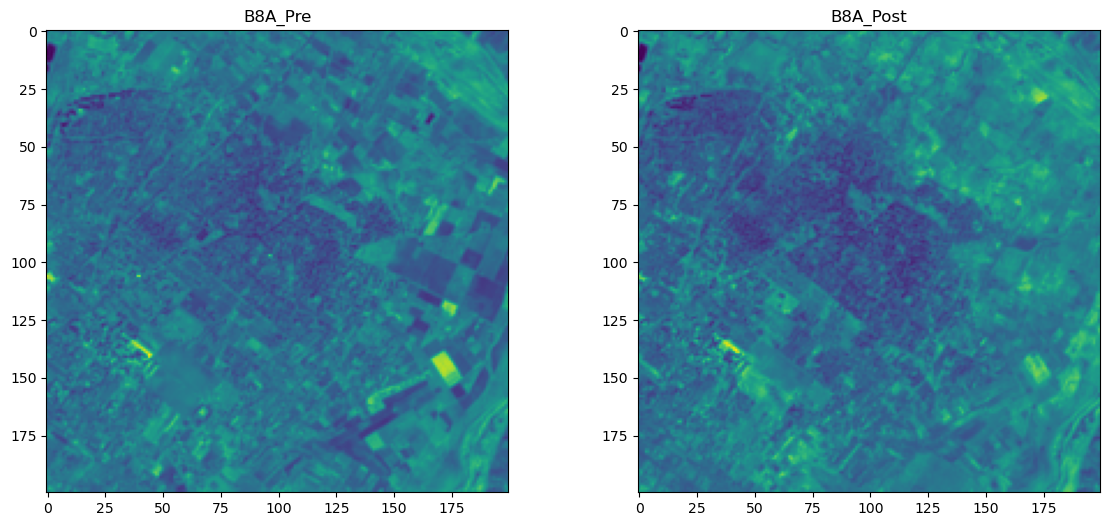

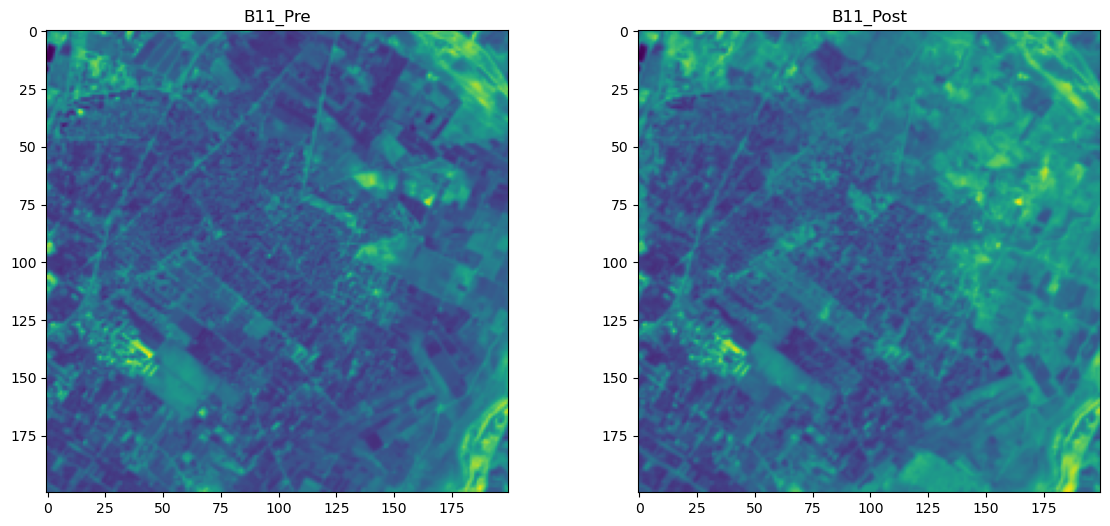

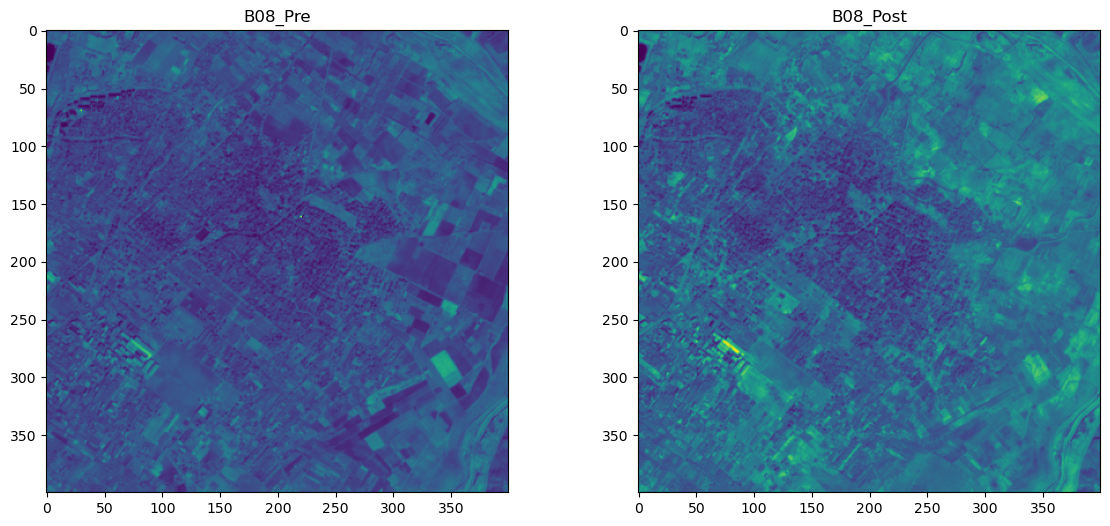

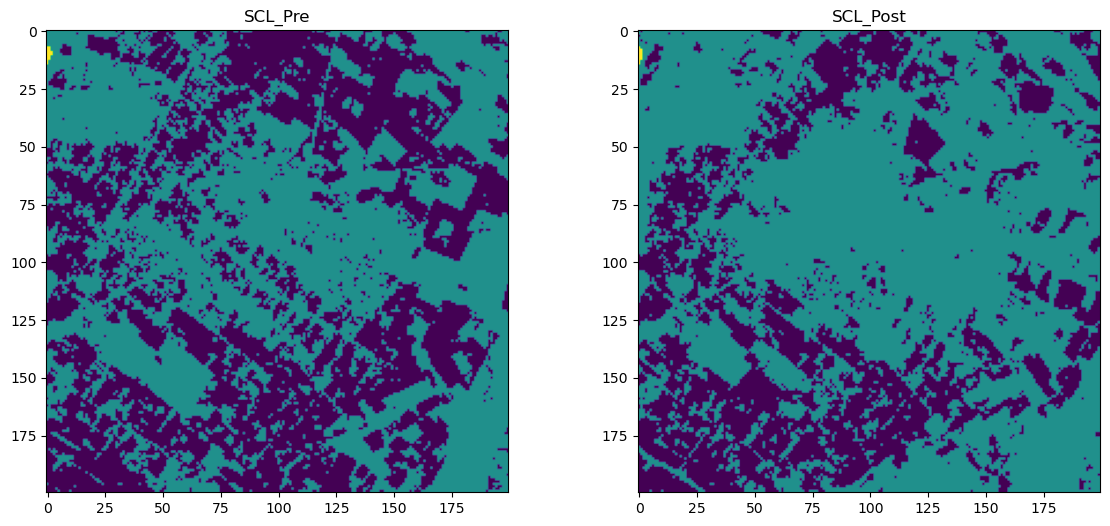

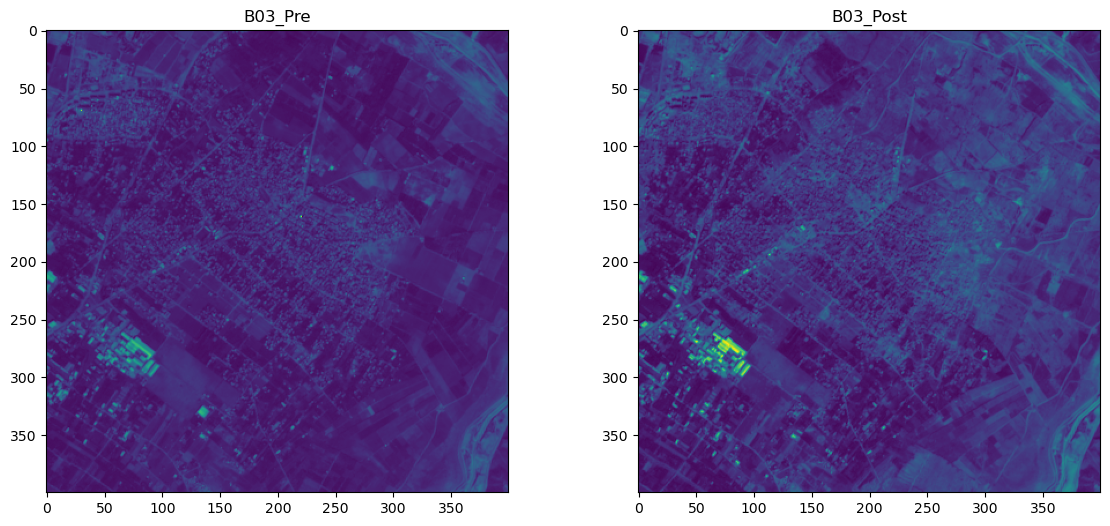

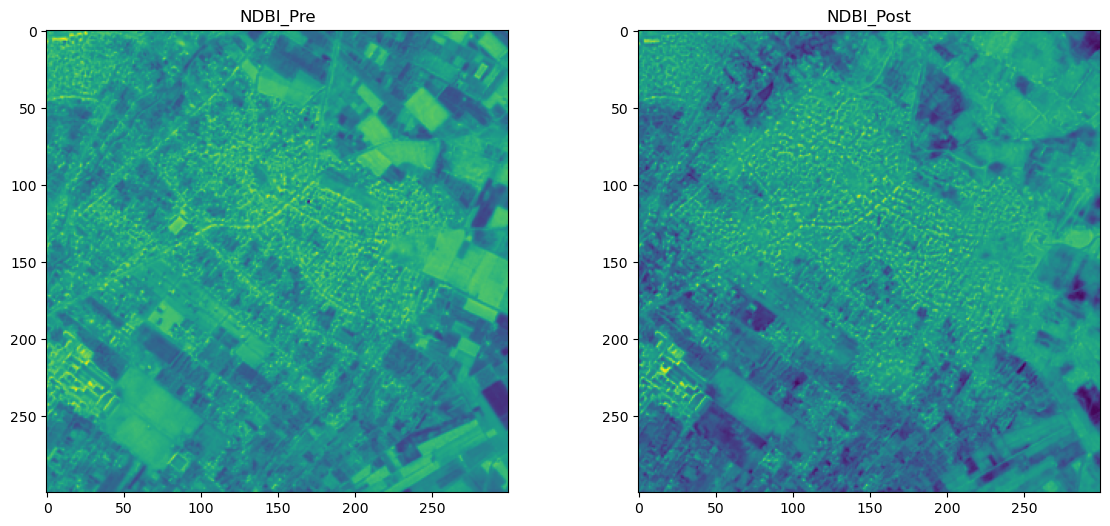

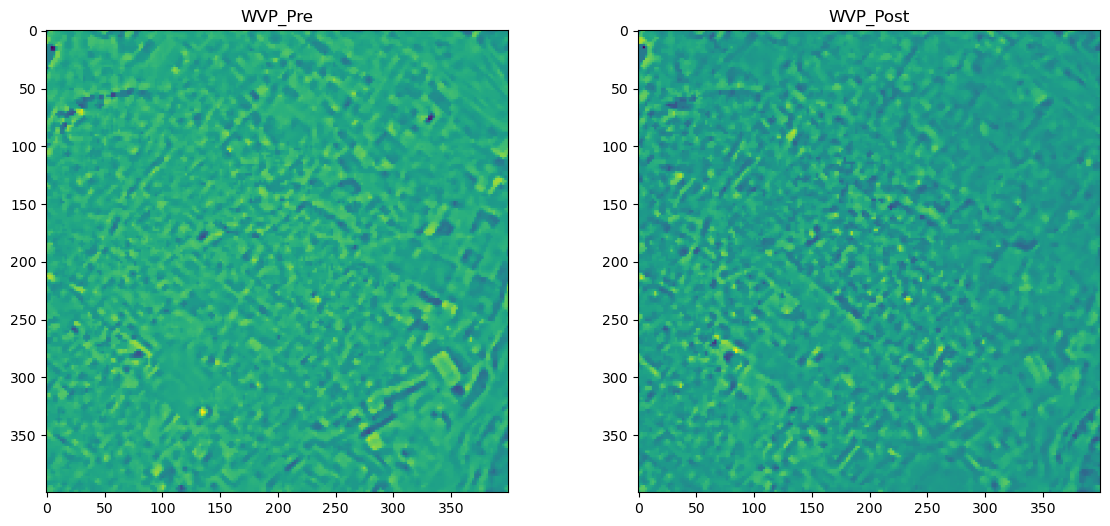

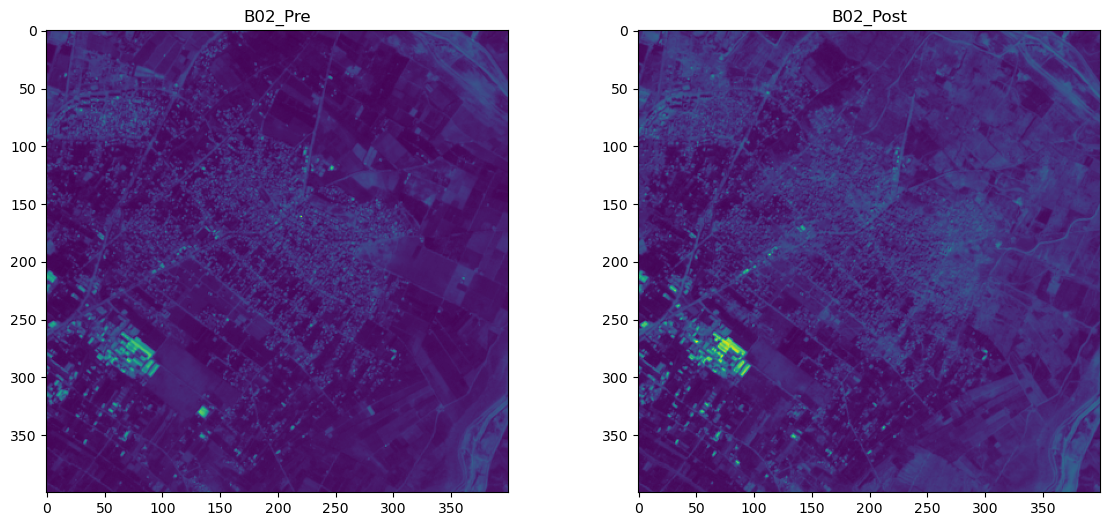

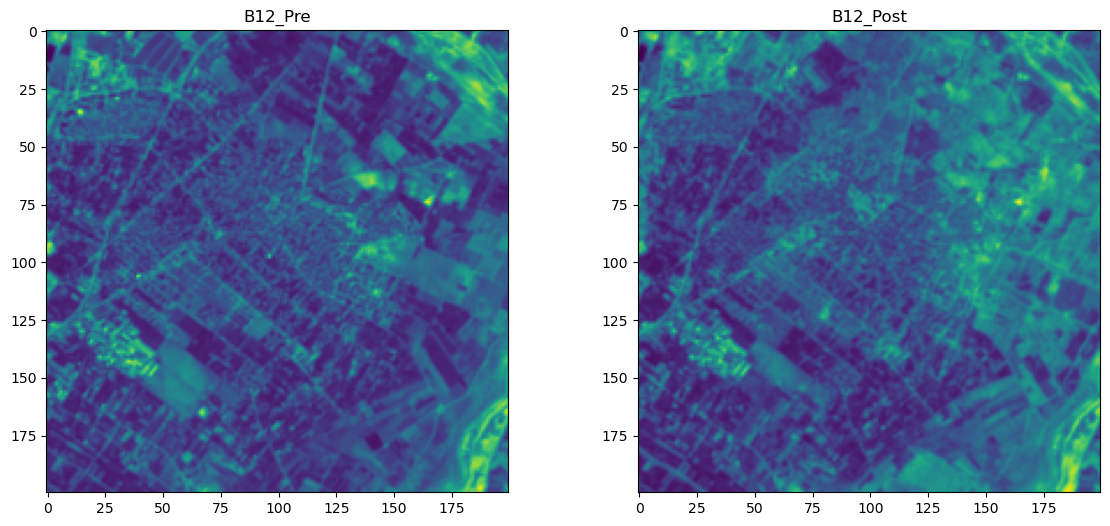

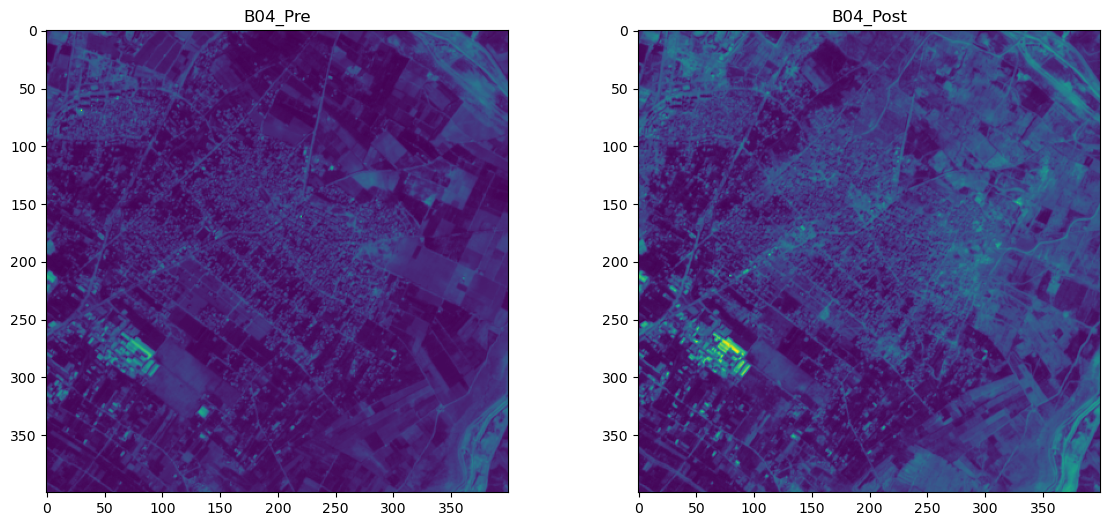

In [3]:
def plot_tif_files(directory):
    tif_files = glob.glob(os.path.join(directory, "*.tif"))
    files_dict = defaultdict(list)
    for tif_file in tif_files:
        base_name = os.path.basename(tif_file)
        # to handle the case when file names are case-insensitive
        if "_pre.tif" in base_name.lower():
            files_dict[base_name.replace("_Pre.tif","").replace("_pre.tif","")].append(("pre", tif_file))
        elif "_post.tif" in base_name.lower():
            files_dict[base_name.replace("_Post.tif","").replace("_post.tif","")].append(("post", tif_file))

    for key in files_dict.keys():
        pre_file_path = next((item[1] for item in files_dict[key] if item[0] == 'pre'), None)
        post_file_path = next((item[1] for item in files_dict[key] if item[0] == 'post'), None)
        if pre_file_path and post_file_path:
            fig, axs = plt.subplots(1, 2, figsize=(14, 6))

            with rasterio.open(pre_file_path) as src_pre:
                raster_pre = src_pre.read(1)
                axs[0].set_title(f'{key}_Pre')
                show(raster_pre, ax=axs[0])

            with rasterio.open(post_file_path) as src_post:
                raster_post = src_post.read(1)
                axs[1].set_title(f'{key}_Post')
                show(raster_post, ax=axs[1])

directory = 'Scratch'
plot_tif_files(directory)

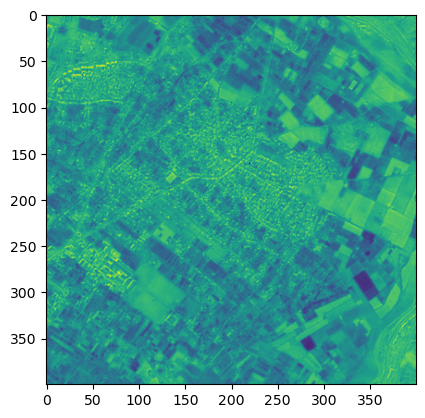

In [4]:
def resample(src_band, shape):
    resampled_band = src_band.read(
        out_shape=shape,
        resampling=Resampling.bilinear
    )
    return resampled_band

def compute_ndbi(nir_band_path, swir_band_path):
    with rasterio.open(nir_band_path) as src:
        nir_band = src.read(1)

    with rasterio.open(swir_band_path) as src:
        swir_band = src.read(1)

        # Check if the shapes match
        if nir_band.shape != swir_band.shape:
            # If they don't match, resample the swir_band to the size of nir_band
            swir_band = resample(src, nir_band.shape)

    np.seterr(divide='ignore', invalid='ignore')  # as we may encounter division by zero

    ndbi = (swir_band.astype(float) - nir_band.astype(float)) / (swir_band.astype(float) + nir_band.astype(float))
    return ndbi


def process_tif_files(directory):
    tif_files = glob.glob(os.path.join(directory, "*_Pre.tif"))
    tif_dict = {}
    for tif_file in tif_files:
        basename = os.path.basename(tif_file)
        band_name = basename.split('_')[0]  # Get the band name from the file name, adjust according to actual names
        tif_dict[band_name] = tif_file

    if "B08" in tif_dict and "B11" in tif_dict:
        nir_band_path = tif_dict["B08"]
        swir_band_path = tif_dict["B11"]
        ndbi = compute_ndbi(nir_band_path, swir_band_path)
        show(ndbi)


directory = 'Scratch'
process_tif_files(directory)

NDBI for _Pre saved to Scratch/NDBI_Pre.tif
NDBI for _Post saved to Scratch/NDBI_Post.tif


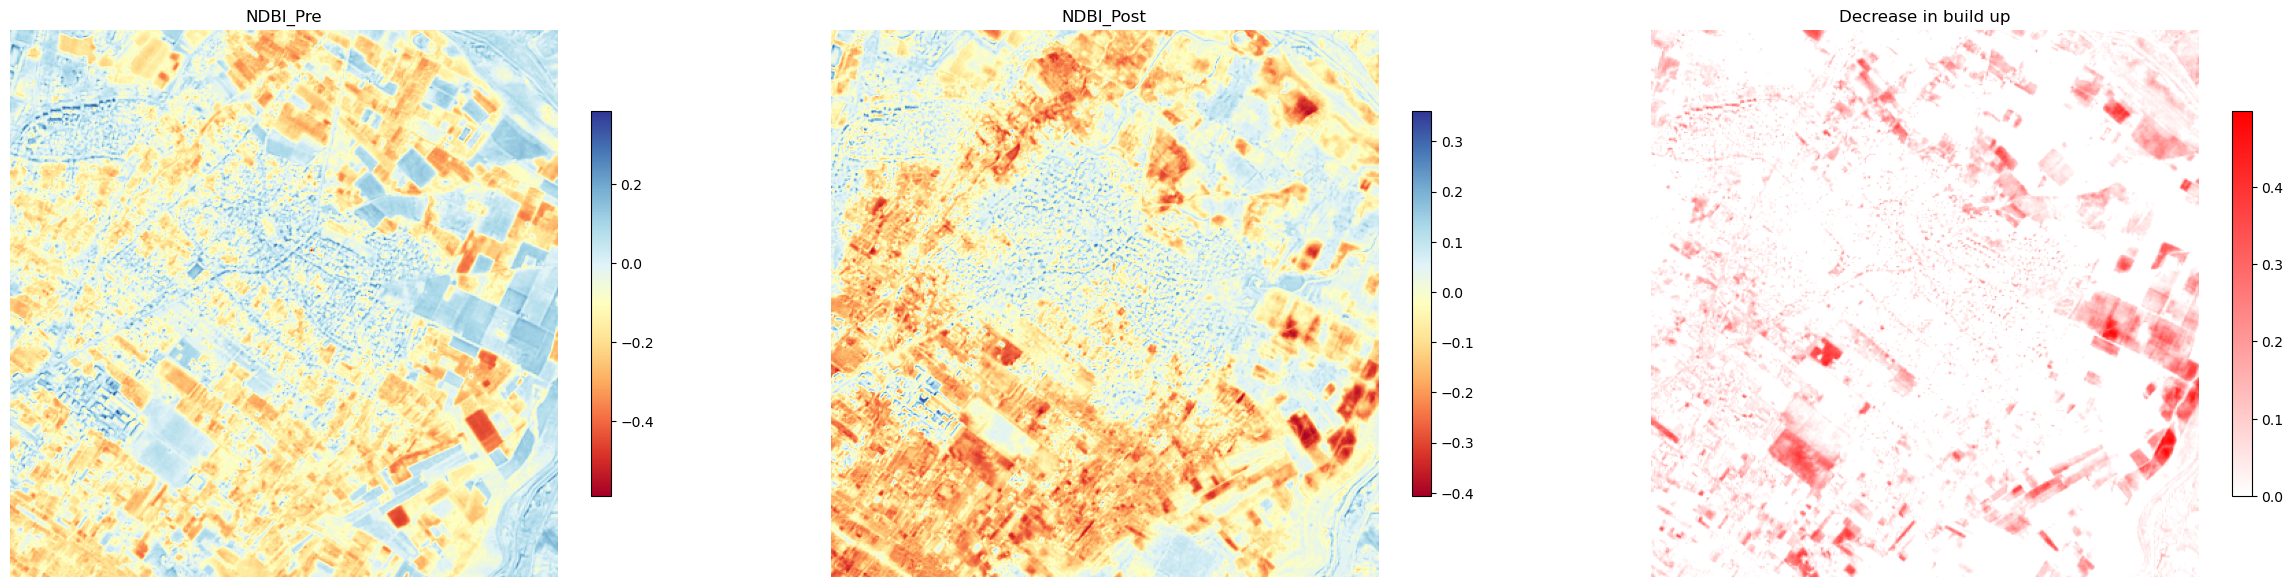

In [11]:
def resample(src, shape):
    resampled_band = src.read(
        out_shape=(src.count, shape[0], shape[1]),
        resampling=Resampling.bilinear
    )

    if len(resampled_band.shape) > 2:
        resampled_band = resampled_band[0]
    return resampled_band


def compute_ndbi(nir_band_path, swir_band_path):
    with rasterio.open(nir_band_path) as src:
        nir_band = src.read(1)
        meta = src.meta  # Get metadata from NIR band

    with rasterio.open(swir_band_path) as src:
        swir_band = src.read(1)

        # Check if the shapes match
        if nir_band.shape != swir_band.shape:
            swir_band = resample(src, nir_band.shape)

    np.seterr(divide='ignore', invalid='ignore')  # as we may encounter division by zero

    ndbi = (swir_band.astype(float) - nir_band.astype(float)) / (swir_band.astype(float) + nir_band.astype(float))

    # Update metadata for output file
    meta.update(dtype=rasterio.float32, count=1)
    return ndbi, meta


def process_tif_files(directory):
    suffixes = ['_Pre', '_Post']
    ndbi_arrays = []

    for suffix in suffixes:
        tif_files = glob.glob(os.path.join(directory, f"*{suffix}.tif"))
        tif_dict = {}
        for tif_file in tif_files:
            basename = os.path.basename(tif_file)
            band_name = basename.split('_')[0]
            tif_dict[band_name] = tif_file

        if "B08" in tif_dict and "B11" in tif_dict:
            nir_band_path = tif_dict["B08"]
            swir_band_path = tif_dict["B11"]
            ndbi, meta = compute_ndbi(nir_band_path, swir_band_path)
            ndbi_arrays.append(ndbi)

            # Save NDBI as a new TIFF file
            output_path = os.path.join(directory, f'NDBI{suffix}.tif')
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(ndbi, 1)
            print(f"NDBI for {suffix} saved to {output_path}")

    # Plotting the NDBI arrays side by side
    import matplotlib.colors as colors
    
    if (len(ndbi_arrays) == 2):
        fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # Change to 3 sub-plots
        titles = ['NDBI_Pre', 'NDBI_Post', 'Decrease in build up']
    
        im0 = axs[0].imshow(ndbi_arrays[0], cmap='RdYlBu')
        axs[0].set_title(titles[0])
        axs[0].axis('off')
        fig.colorbar(im0, ax=axs[0], shrink=0.5)
    
        im1 = axs[1].imshow(ndbi_arrays[1], cmap='RdYlBu')
        axs[1].set_title(titles[1])
        axs[1].axis('off')
        fig.colorbar(im1, ax=axs[1], shrink=0.5)
    
        # difference = ndbi_arrays[0] - ndbi_arrays[1]
        # im2 = axs[2].imshow(difference, cmap='coolwarm')
        # axs[2].set_title(titles[2])
        # axs[2].axis('off')
        # fig.colorbar(im2, ax=axs[2], shrink=0.5)
        
        difference = ndbi_arrays[0] - ndbi_arrays[1]
        cmap = colors.LinearSegmentedColormap.from_list("", ["white","red"])
        im = axs[2].imshow(np.maximum(difference, 0), cmap=cmap)  # Masking the increase in build up
        axs[2].set_title(titles[2])
        axs[2].axis('off')
        fig.colorbar(im, ax=axs[2], shrink=0.5)
    
        plt.show()


directory = 'Scratch'
process_tif_files(directory)

De plaatjes (.tif) kunnen gewoon in QGIS worden geladen boven op de polygons en damage sites datapunten
Het verschil van de pre en post buildup kaarten, het vershill geeft alleen de plekken weer waar de afname in buildup positief is, dwz dat er gebouwen weg zijn. En dus niet als er een negatieve waarde is (wat zou impliceren dat er nieuwe gebouwen bij zijn gekomen). Dit is mede doordat er precies een jaar tussen de fotos zitten dus op deze manier worden gebouwen die in de tussentijd zijn gebouwd niet meegenomen.